## Импорты ##

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MultiheadAttention as Attention
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM
from torch.utils.data import Dataset, DataLoader
import json
from nltk import word_tokenize
import string
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryAccuracy
from matplotlib import pyplot as plt
import pandas as pd
from tbparse import SummaryReader
import ast
import random
import requests
from tqdm import tqdm

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

SEED = 42
set_random_seed(SEED)
    
# some previously used models
# "ai-forever/ruBert-large" (suffix_mask1)
# "ai-forever/ruElectra-large" (suffix_mask1)
# "DeepPavlov/rubert-base-cased-conversational" (suffix_mask1)
# "google-bert/bert-base-multilingual-cased" (suffix_mask1)
# "FacebookAI/xlm-roberta-large" (suffix_mask2)
# "ai-forever/ruT5-large" (suffix_mask2)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
import requests, zipfile, io

url = 'https://raw.githubusercontent.com/rossyaykin/RuOpinionNE/refs/heads/main/src/src.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('')

In [3]:
from src.utils import load_jsonl, parse_data, dict2tuple, str2list, df2structure, extract_tuple, save_jsonl
from src.collator import Collator, CustomDataset, plot_results, visualize, make_preds
from src.evaluation import do_eval_core

## Данные ##

### Загружаем ###

In [4]:
train_path = "data/full.jsonl"
test_path = "data/gold.jsonl"
trans_path = "data/translated.jsonl"
gen_path = "data/generated.jsonl"

# url = 'https://raw.githubusercontent.com/rossyaykin/RuOpinionNE/refs/heads/main/data/full.jsonl'
# train = load_jsonl(url, train_path)
# url = 'https://raw.githubusercontent.com/rossyaykin/RuOpinionNE/refs/heads/main/data/gold.jsonl'
# test = load_jsonl(url, test_path)
# url = 'https://raw.githubusercontent.com/rossyaykin/RuOpinionNE/refs/heads/main/data/translated.jsonl'
# trans = load_jsonl(url, trans_path)
# url = 'https://raw.githubusercontent.com/rossyaykin/RuOpinionNE/refs/heads/main/data/generated.jsonl'
# gen = load_jsonl(url, gen_path)

url = 'https://raw.githubusercontent.com/rossyaykin/RuOpinionNE/refs/heads/main/data/data.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('')

train = parse_data(train_path)
test = parse_data(test_path)
trans = parse_data(trans_path)
gen = parse_data(gen_path)

In [5]:
# if using 'train' (2044) instead of 'full' (2556)
train_path = 'data/train.jsonl'
train = parse_data(train_path)

print(f'{len(train)=}')
print(f'{len(test)=}')
print(f'{len(trans)=}')
print(f'{len(gen)=}')

len(train)=2044
len(test)=512
len(trans)=3831
len(gen)=3000


In [6]:
gen[0]

{'sent_id': 0,
 'text': 'Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия.',
 'opinions': []}

In [7]:
trans[-1]

{'sent_id': 'multibooked/corpora/eu/france-voyage_1-3',
 'text': 'Столовая также очень высоко оформлена и завтрак, чтобы выбрать Христону много вещей.',
 'opinions': [{'Source': [['NULL'], ['0:0']],
   'Target': [['завтрак'], ['0:0']],
   'Polar_expression': [['Христону'], ['0:0']],
   'Polarity': 'POS'}]}

### Датасеты и даталоадеры ###

In [8]:
trainset = CustomDataset(train_path)
testset = CustomDataset(test_path)
genset = CustomDataset(gen_path)
transset = CustomDataset(trans_path)

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruRoberta-large")
model = AutoModel.from_pretrained("ai-forever/ruRoberta-large")
mycol = Collator(tokenizer)

b_s = 32
n_workers = 1

train_loader = DataLoader(trainset, batch_size = b_s, shuffle = True,
                          collate_fn = mycol.collate, num_workers = n_workers)
test_loader = DataLoader(testset, batch_size = b_s, shuffle = False,
                         collate_fn = mycol.collate, num_workers = n_workers)
trans_loader = DataLoader(transset, batch_size = b_s, shuffle = True,
                          collate_fn = mycol.collate, num_workers = n_workers)
gen_loader = DataLoader(genset, batch_size = b_s, shuffle = True,
                          collate_fn = mycol.collate, num_workers = n_workers)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
train_ids, train_features, train_labels = next(iter(train_loader))
print(f"train features input_ids shape:\n{train_features['input_ids'].shape}")
print(f"train labels (maps) shape:\n{train_labels.shape}")

train features input_ids shape:
torch.Size([32, 63])
train labels (maps) shape:
torch.Size([32, 2, 63, 63])


### Проверяем отображения ###

In [10]:
check_id = 0

for i in range(len(trainset)):
    if trainset[i]['sent_id'] == train_ids[check_id]:
        sent_id, text, opinions = i, trainset[i]['text'], trainset[i]['opinions']
        break
print(f'original opinions:\n{opinions}')
print(f'opinions to maps and back:\n{mycol.maps2tuple(text, train_labels[check_id])}')

original opinions:
[{'Source': [['Коммунистической партии Китая'], ['66:95']], 'Target': [['Ли Пэн'], ['35:41']], 'Polar_expression': [['превосходным'], ['46:58']], 'Polarity': 'POS'}, {'Source': [['Коммунистической партии Китая'], ['66:95']], 'Target': [['Ли Пэн'], ['35:41']], 'Polar_expression': [['испытанным'], ['97:107']], 'Polarity': 'POS'}, {'Source': [['Коммунистической партии Китая'], ['66:95']], 'Target': [['Ли Пэн'], ['35:41']], 'Polar_expression': [['преданным коммунистическим борцом'], ['110:143']], 'Polarity': 'POS'}, {'Source': [['Коммунистической партии Китая'], ['66:95']], 'Target': [['Ли Пэн'], ['35:41']], 'Polar_expression': [['выдающимся пролетарским революционером'], ['145:183']], 'Polarity': 'POS'}, {'Source': [['Ли Пэн'], ['35:41']], 'Target': [['Коммунистической партии Китая'], ['66:95']], 'Polar_expression': [['членом'], ['59:65']], 'Polarity': 'POS'}]
opinions to maps and back:
[['Коммунистической партии Китая', 'Ли Пэн', 'превосходным', 'POS'], ['Ли Пэн', 'Ком

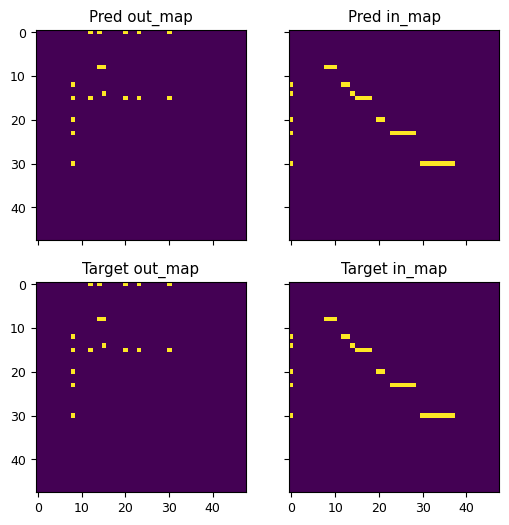

In [12]:
inMap = mycol.in_map(trainset[sent_id], 48)
outMap = mycol.out_map(trainset[sent_id], 48)
plot_results((inMap, outMap), (inMap, outMap), cmap='viridis')

## Проверка модели ##

In [18]:
class EmbedderModel(nn.Module):
    def __init__(self, embedder, emb_size = 1024, att_heads = 4,
                 lstm_hidden = 512, lstm_layers = 2,
                 lin_hidden = 512, convolution = False):
        super(EmbedderModel, self).__init__()
        self.emb_size = emb_size
        self.att_heads = att_heads
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lin_hidden = lin_hidden
        self.convolution = convolution
        
        # embedder (RuBert or RuRoberta)
        self.embedder = embedder
        
        # freeze by default
        for param in self.embedder.parameters():
            param.requires_grad = False
        
        # common part
        self.lstm = nn.LSTM(emb_size, lstm_hidden, lstm_layers, batch_first = True)
        self.att = nn.MultiheadAttention(lstm_hidden, att_heads)
        
        # split part
        # head in, dependent in
        self.fc_hi = nn.Sequential(nn.Linear(lstm_hidden, lin_hidden),
                                  nn.LayerNorm(lin_hidden),
                                  nn.LeakyReLU())
        self.fc_di = nn.Sequential(nn.Linear(lstm_hidden, lin_hidden),
                                  nn.LayerNorm(lin_hidden),
                                  nn.LeakyReLU())
        # head out, dependent out
        self.fc_ho = nn.Sequential(nn.Linear(lstm_hidden, lin_hidden),
                                  nn.LayerNorm(lin_hidden),
                                  nn.LeakyReLU())
        self.fc_do = nn.Sequential(nn.Linear(lstm_hidden, lin_hidden),
                                  nn.LayerNorm(lin_hidden),
                                  nn.LeakyReLU())
        # self.classifier_in = PseudoBilinear(lin_hidden)
        # self.classifier_out = PseudoBilinear(lin_hidden)
        self.classifier_in = nn.MultiheadAttention(lin_hidden, att_heads, batch_first = True)
        self.classifier_out = nn.MultiheadAttention(lin_hidden, att_heads, batch_first = True)
        # convolutions
        self.combine = nn.Sequential(nn.Conv2d(in_channels = 2,
                                              out_channels = 2,
                                              kernel_size = 3,
                                              padding = 1),
                                    nn.BatchNorm2d(2),
                                    nn.LeakyReLU(),
                                    nn.Conv2d(in_channels = 2,
                                              out_channels = 2,
                                              kernel_size = 3,
                                              padding = 1))
        # not used
        self.activate = nn.Sigmoid()
        
    def freeze(self):
        # freeze embedder weights
        for param in self.embedder.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        # unfreeze embedder weights
        for param in self.embedder.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        out = self.embedder(**x)['last_hidden_state']
        out, _ = self.lstm(out)
        out, _ = self.att(out, out, out)
        head_in = self.fc_hi(out)
        dep_in = self.fc_di(out)
        # scores_in = self.classifier_out(head_in, dep_in)
        # scores_in = self.activate(scores_in)
        _, scores_in = self.classifier_in(head_in, dep_in, dep_in)
        head_out = self.fc_ho(out)
        dep_out = self.fc_do(out)
        # scores_out = self.classifier_out(head_out, dep_out)
        # scores_out = self.activate(scores_out)
        _, scores_out = self.classifier_out(head_out, dep_out, dep_out)
        if not self.convolution:
            return torch.stack((scores_in, scores_out), dim = 1)
        result = self.combine(torch.stack((scores_in, scores_out), dim = 1))
        return F.softmax(result, dim = -1)
        # return self.activate(result)

class PseudoBilinear(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, emb_size):
        super(PseudoBilinear, self).__init__()
        self.emb_size = emb_size
        self.lin = nn.Sequential(nn.Linear(emb_size, emb_size),
                                 nn.LeakyReLU())

    def forward(self, x1, x2):
        out = self.lin(x1)
        return torch.bmm(out, x2.swapaxes(1, 2))

In [12]:
EM = EmbedderModel(model, lstm_hidden = 1024)
res = EM(train_features)
print(f'output shape: {res.shape}')

output shape: torch.Size([32, 2, 63, 63])


In [13]:
# from torchmetrics.classification import BinaryAccuracy
tm = BinaryAccuracy(threshold=0.02)
tm(res, train_labels)

tensor(0.9988)

## Инференс ###

### Lightning model ###

In [14]:
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from warnings import simplefilter
import torchmetrics
from torchmetrics import MetricCollection

In [15]:
class Lit(L.LightningModule):
    def __init__(self, model, lr=0.0003):
        super().__init__()
        self.save_hyperparameters(logger=False)

        # for optimizer and shaduler
        self.lr = lr

        # model
        self.model = model
        # self.criterion = BCEWithL2
        self.criterion = nn.BCELoss()

        # metrics
        self.metrics = MetricCollection({'BA_005' : BinaryAccuracy(0.05),
                                         'BA_01' : BinaryAccuracy(0.1),
                                         'BA_02' : BinaryAccuracy(0.2),
                                         'MAE' : torchmetrics.regression.MeanAbsoluteError(),
                                         'MSE' : torchmetrics.regression.MeanSquaredError()
        })
        # self.train_metrics = MetricCollection([MAE, MSE])
        # self.val_metrics = MetricCollection([MAE, MSE])
        self.train_metrics = self.metrics.clone(postfix="/train")
        self.val_metrics = self.metrics.clone(postfix="/val")

    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss/val",  # only for self.log
            },
        }

    def training_step(self, batch, batch_idx):
        # _ = sent_ids
        _, x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss/train", loss, prog_bar=True)
        self.train_metrics.update(out, y)
        return loss

    def validation_step(self, batch, batch_idx):
        # _ = sent_ids
        _, x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss/val", loss, prog_bar=True)
        self.val_metrics.update(out, y)

    def on_train_epoch_end(self):        
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        # val_metrics = self.val_metrics.compute()
        self.log_dict(self.val_metrics.compute())
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        # _ = sent_ids
        _, x, y = batch
        out = self.model(x)
        self.metrics.update(out, y)

    def on_test_epoch_end(self):
        self.log_dict(self.metrics.compute())
        self.metrics.reset()

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./lightning_logs --port 6007

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

### Этап 1: основной датасет ###

In [20]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruRoberta-large")
model = AutoModel.from_pretrained("ai-forever/ruRoberta-large")
EM = EmbedderModel(model, lstm_hidden = 1024)

unfreeze = True
if unfreeze:
    EM.unfreeze()

max_epochs = 10
LModel = Lit(EM)

# checkpoint_callback = ModelCheckpoint(
#     monitor="metrics/val", mode="min", filename="best"
# )

exp_name = f"stage1_unfreeze{unfreeze}_{max_epochs}"
logger = TensorBoardLogger(save_dir=f"./lightning_logs/", name=exp_name)

trainer = L.Trainer(
    max_epochs=max_epochs,
    num_sanity_val_steps=0,
    logger=logger,
    enable_checkpointing=False,
    enable_progress_bar=False
)

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model=LModel,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader)

Missing logger folder: ./lightning_logs/stage1_unfreeze_10
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EmbedderModel    | 380 M 
1 | criterion     | BCELoss          | 0     
2 | metrics       | MetricCollection | 0     
3 | train_metrics | MetricCollection | 0     
4 | val_metrics   | MetricCollection | 0     
---------------------------------------------------
380 M     Trainable params
0         Non-trainable params
380 M     Total params
1,522.225 Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
huggingface/tokenizers: The current process just got forked, after parallelism has alre

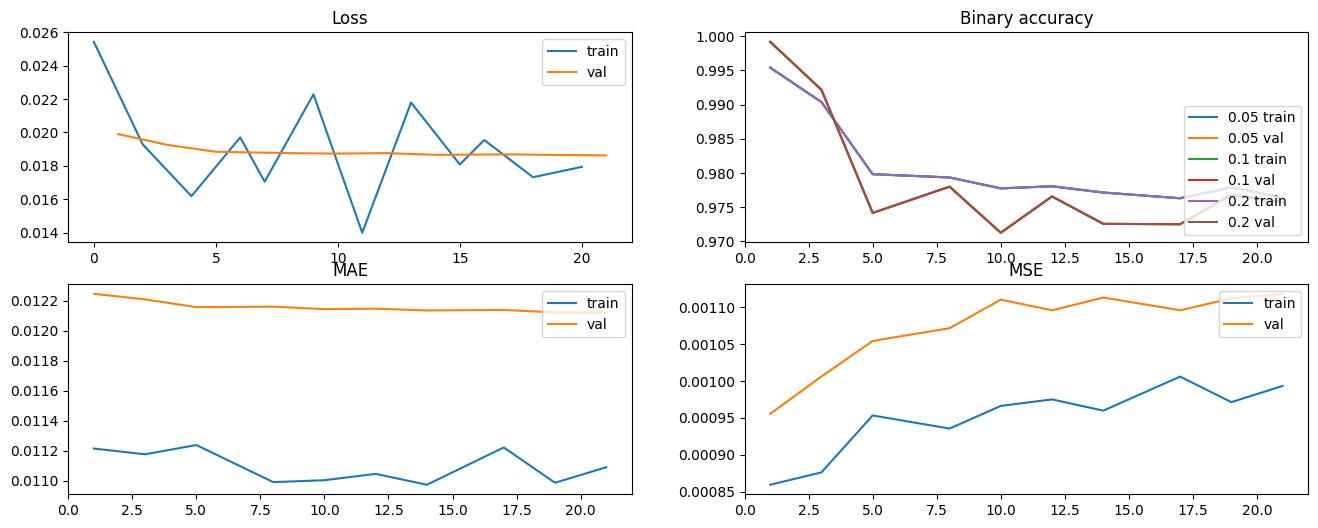

In [22]:
log_dir = trainer.logger.experiment.get_logdir()  # lightning_logs/version_x
visualize(log_dir)

### Этап 2: переводные данные ###

In [27]:
max_epochs = 10
# LModel = Lit(EM)

# checkpoint_callback = ModelCheckpoint(
#     monitor="metrics/val", mode="min", filename="best"
# )

exp_name = f"stage2_unfreeze_{max_epochs}"
logger = TensorBoardLogger(save_dir=f"./lightning_logs/", name=exp_name)

trainer = L.Trainer(
    max_epochs=max_epochs,
    num_sanity_val_steps=0,
    logger=logger,
    enable_checkpointing=False,
    enable_progress_bar=False
)

trainer.fit(model=LModel,
    train_dataloaders=trans_loader,
    val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/stage2_unfreeze_10
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EmbedderModel    | 380 M 
1 | criterion     | BCELoss          | 0     
2 | metrics       | MetricCollection | 0     
3 | train_metrics | MetricCollection | 0     
4 | val_metrics   | MetricCollection | 0     
---------------------------------------------------
380 M     Trainable params
0         Non-trainable params
380 M     Total params
1,522.225 Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument

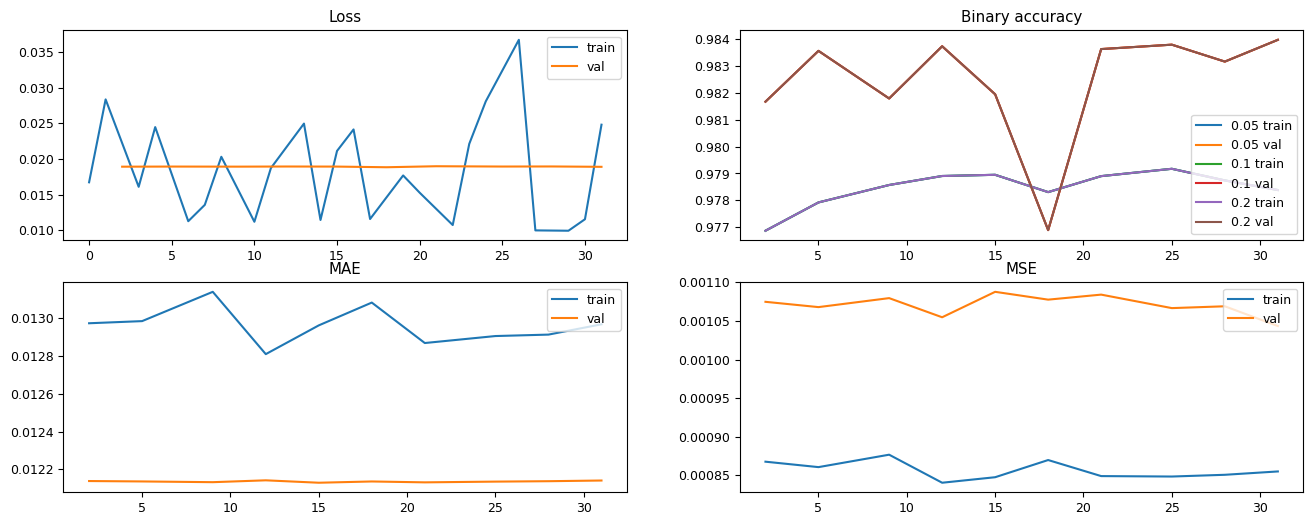

In [28]:
log_dir = trainer.logger.experiment.get_logdir()  # lightning_logs/version_x
visualize(log_dir)

### Этап 3: сгенерированные данные ###

In [29]:
max_epochs = 10

exp_name = f"stage3_unfreeze_{max_epochs}"
logger = TensorBoardLogger(save_dir=f"./lightning_logs/", name=exp_name)

trainer = L.Trainer(
    max_epochs=max_epochs,
    num_sanity_val_steps=0,
    logger=logger,
    enable_checkpointing=False,
    enable_progress_bar=False
)

trainer.fit(model=LModel,
    train_dataloaders=gen_loader,
    val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/stage3_unfreeze_10
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EmbedderModel    | 380 M 
1 | criterion     | BCELoss          | 0     
2 | metrics       | MetricCollection | 0     
3 | train_metrics | MetricCollection | 0     
4 | val_metrics   | MetricCollection | 0     
---------------------------------------------------
380 M     Trainable params
0         Non-trainable params
380 M     Total params
1,522.225 Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument

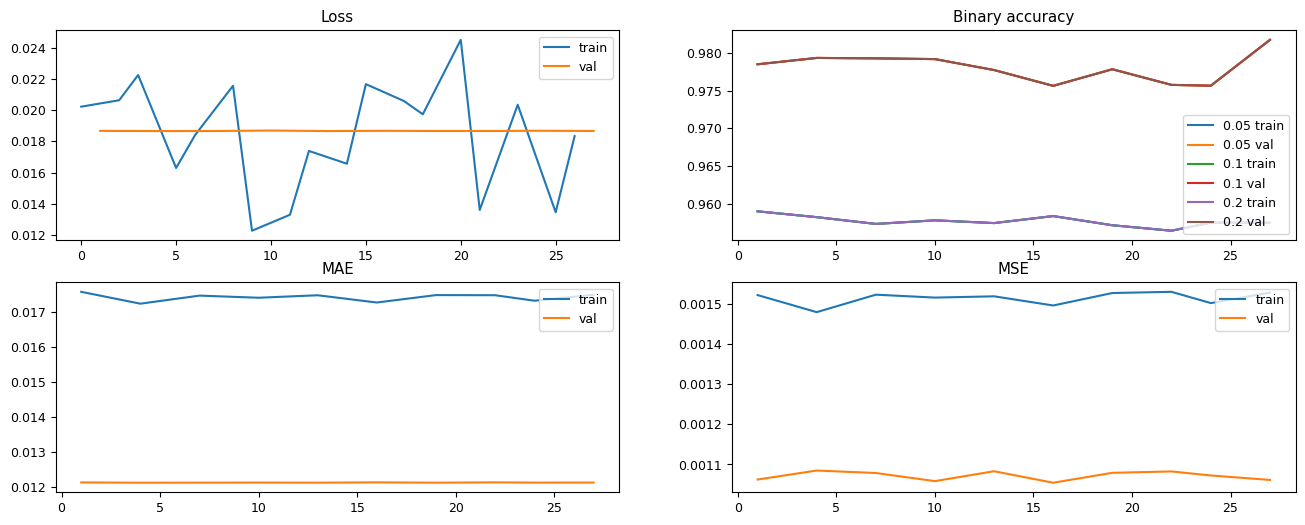

In [30]:
log_dir = trainer.logger.experiment.get_logdir()  # lightning_logs/version_x
visualize(log_dir)

### Этап 4: основной датасет ###

In [31]:
# unfreeze layers 22--23
# for name, param in EM.embedder.named_parameters(): 
#     if ".22." in name or ".23." in name:
#         param.requires_grad = True

max_epochs = 20

exp_name = f"stage4_unfreeze_{max_epochs}"
logger = TensorBoardLogger(save_dir=f"./lightning_logs/", name=exp_name)

trainer = L.Trainer(
    max_epochs=max_epochs,
    num_sanity_val_steps=0,
    logger=logger,
    enable_checkpointing=False,
    enable_progress_bar=False
)

trainer.fit(model=LModel,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/stage4_unfreeze_20
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EmbedderModel    | 380 M 
1 | criterion     | BCELoss          | 0     
2 | metrics       | MetricCollection | 0     
3 | train_metrics | MetricCollection | 0     
4 | val_metrics   | MetricCollection | 0     
---------------------------------------------------
380 M     Trainable params
0         Non-trainable params
380 M     Total params
1,522.225 Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument

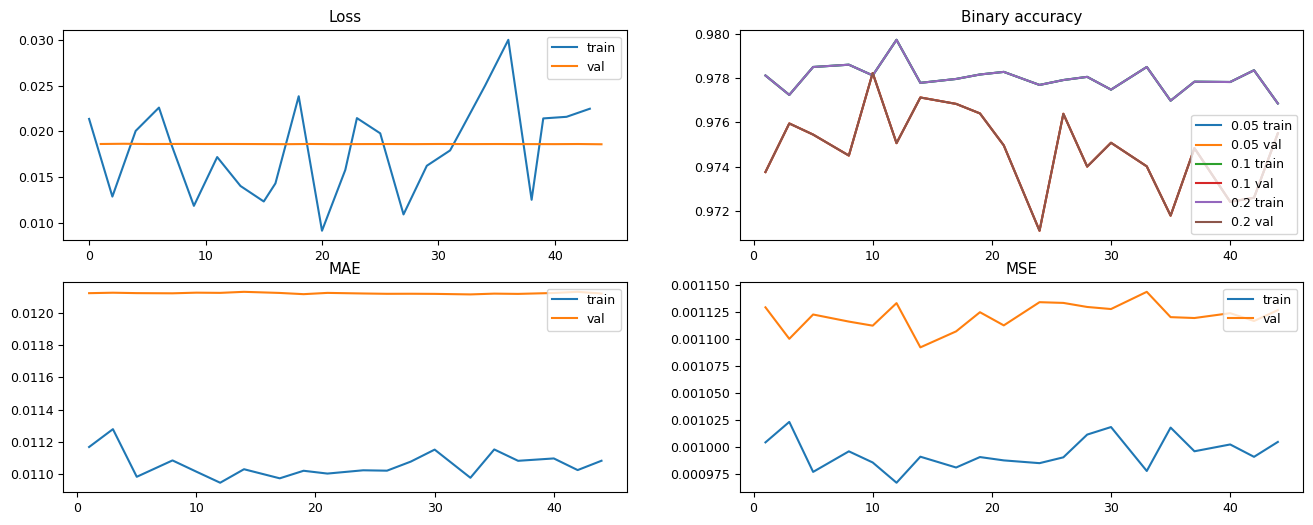

In [32]:
log_dir = trainer.logger.experiment.get_logdir()  # lightning_logs/version_x
visualize(log_dir)

## Оценка ##

In [33]:
train_ids, train_features, train_labels = next(iter(train_loader))
print(f"train features input_ids shape:\n{train_features['input_ids'].shape}")
print(f"train labels (maps) shape:\n{train_labels.shape}")
res = LModel.model(train_features)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


train features input_ids shape:
torch.Size([32, 91])
train labels (maps) shape:
torch.Size([32, 2, 91, 91])


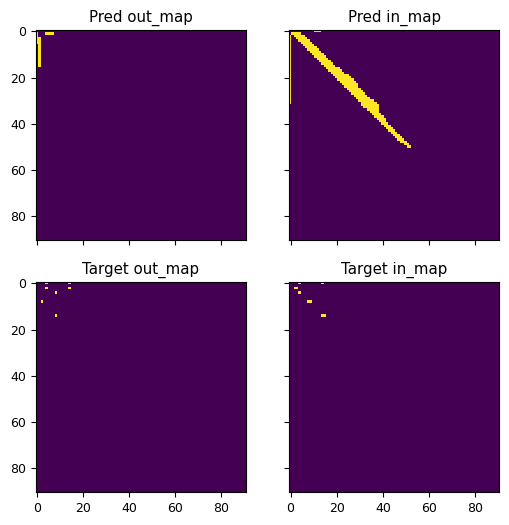

In [35]:
check_id = 1
plot_results(mycol.logits2preds(res[check_id], 0.05), train_labels[check_id], cmap = 'viridis')

In [37]:
for i in range(len(trainset)):
    if trainset[i]['sent_id'] == train_ids[check_id]:
        sent_id, text, opinions = i, trainset[i]['text'], trainset[i]['opinions']
        break
print(f'original opinions:\n{opinions}')
print(f'predicted:\n{mycol.maps2tuple(text, mycol.logits2preds(res[check_id], 0.05))}')

original opinions:
[{'Source': [['Сурков'], ['6:12']], 'Target': [['Маркина'], ['49:56']], 'Polar_expression': [['пренебрежительно'], ['13:29']], 'Polarity': 'NEG'}, {'Source': [['Сурков'], ['6:12']], 'Target': [['Маркина'], ['49:56']], 'Polar_expression': [['графоманию'], ['80:90']], 'Polarity': 'NEG'}]
predicted:
[]


## Предсказания ##

In [39]:
# val_path = "data/validation.jsonl"

# url = 'https://raw.githubusercontent.com/rossyaykin/RuOpinionNE/refs/heads/main/data/validation.jsonl'
# val = load_jsonl(url, val_path)
# # val = parse_data(val_path)
# valset = CustomDataset(val_path)
# print(len(valset))

1316


In [60]:
threshold = 0.05

result = make_preds(LModel.model, testset, mycol, threshold)

100%|██████████| 512/512 [01:41<00:00,  5.07it/s]


In [61]:
result.head()

,sent_id,text,pred
0,1266,Елизавета Глинка во время эвакуации детей из Д...,[]
1,1749,Однако Песков настаивает на другой версии прич...,[]
2,2050,25 января 2014 года Владимир Макеенко назначен...,[]
3,393,С вертолета было произведено 15 выстрелов по з...,"[[NULL, [], С вертолета было произведено 15, P..."
4,1544,Как сообщают в микроблоге представители арт-гр...,[]


In [63]:
f1 = do_eval_core(test, df2structure(result))
f1

0.0

In [105]:
path = f'result'
result.to_csv(f'{path}.csv', index = False)

In [106]:
final = df2structure(result)
final[2]

{'sent_id': 2,
 'text': 'Сама женщина заявила, что встречаться с сыном ей пришлось в присутствии видеокамеры.',
 'opinions': []}

In [107]:
path = f'result'
save_jsonl(final, path)